In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

from quantipy.assets import Currency, Equity
from quantipy.trading import Broker, TripleMovingAverage
from quantipy.backtest import Backtester

%matplotlib inline
warnings.filterwarnings('ignore')

# backtest period
BACKTEST_START = '2016-01-01'
LIVE_START = '2019-01-01'

# trading universe
CAPITAL = 10_000
usd = Currency('USD')
spy = Equity('SPY', 'SPY')
ndq = Equity('NASDAQ', '^IXIC')
MKT = [spy, ndq]
BENCHMARK = 'SPY'

# strategy
STRATEGY = TripleMovingAverage([ndq], {})

# strategy parameters

# PARAMS = {
#     'history1': [3, 4, 5, 6], 
#     'history2': [7, 9, 10, 12, 15],
#     'history3': [21, 24, 27, 30]
# }

PARAMS = {
    'history1': [4], 
    'history2': [15],
    'history3': [21, 30]
}

TARGET = 'sortino'

{'history1': 4, 'history2': 15, 'history3': 21}
Date
2016-02-05 00:00:00-05:00    10000.000000
2016-02-08 00:00:00-05:00     9725.354393
2016-02-09 00:00:00-05:00     9575.114158
2016-02-10 00:00:00-05:00     9575.114158
2016-02-11 00:00:00-05:00     9575.114158
                                 ...     
2018-12-24 00:00:00-05:00    10835.988276
2018-12-26 00:00:00-05:00    10835.988276
2018-12-27 00:00:00-05:00    10835.988276
2018-12-28 00:00:00-05:00    10835.988276
2018-12-31 00:00:00-05:00    10835.988276
Length: 731, dtype: float64
Score: 0.5608623120047312
{'history1': 4, 'history2': 15, 'history3': 30}
Date
2016-02-19 00:00:00-05:00    10000.000000
2016-02-22 00:00:00-05:00    10061.661828
2016-02-23 00:00:00-05:00    10194.021203
2016-02-24 00:00:00-05:00    10059.961633
2016-02-25 00:00:00-05:00    10138.021203
                                 ...     
2018-12-24 00:00:00-05:00    11487.498920
2018-12-26 00:00:00-05:00    11487.498920
2018-12-27 00:00:00-05:00    11487.498920


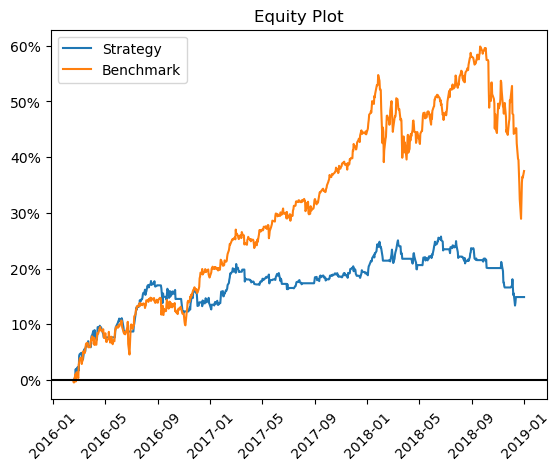

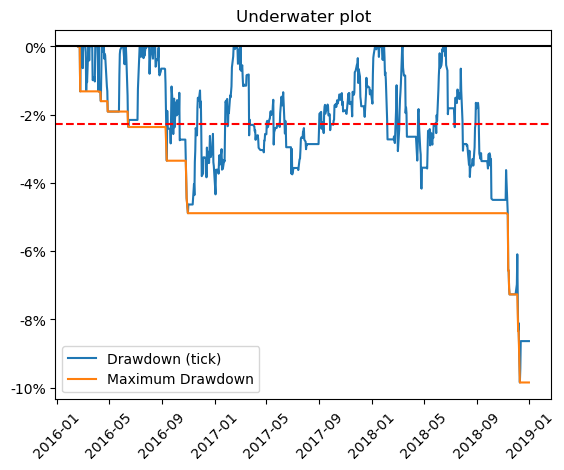

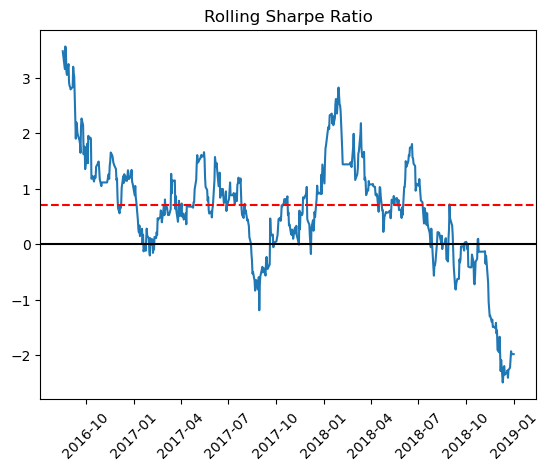

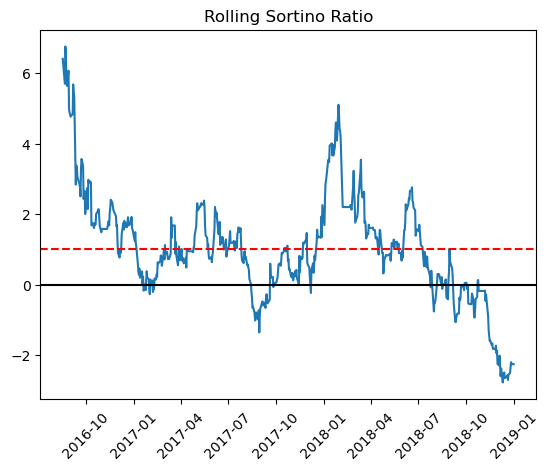

In [2]:
# getting data
data = {}
for asset in MKT:
    ticker = yf.ticker.Ticker(asset.symbol)
    ticker_data = ticker.history(start=BACKTEST_START, end=LIVE_START,
                                 interval='1d')
    data[asset.symbol] = ticker_data

broker = Broker(data=data, initial_capital=CAPITAL, currency=usd)
backtester = Backtester(data)

opt_results = backtester.optimize(
    STRATEGY, broker, PARAMS, target=TARGET, save_logs=False, benchmark=BENCHMARK
)

print(opt_results['best_params'])
backtester.show_report()

Backtest Results
----------------------------------------
Metric           Strategy      Benchmark
----------------------------------------
Total Return:      89.65%        142.18%
Avg gain (day):     0.70%          0.83%
Avg loss (day):    -0.70%         -0.86%
Volatility:        0.1251         0.2025
Sharpe Ratio:      1.0147         0.8961
Sortino Ratio:     1.4648         1.2575
----------------------------------------
Max Drawdown:     -20.88%        -33.72%
Avg Drawdown:      -6.06%         -5.75%
Avg DD Bars:           20             11
Longest DD:           569            488
----------------------------------------
Time in Market:    69.30%           100%
Trades:                44
Best Win:          30.86%
Avg Win:            5.98%
Worst Loss:       -10.40%
Avg Loss:          -2.74%
Win/Loss ratio:      1.20
Win %:             54.55%


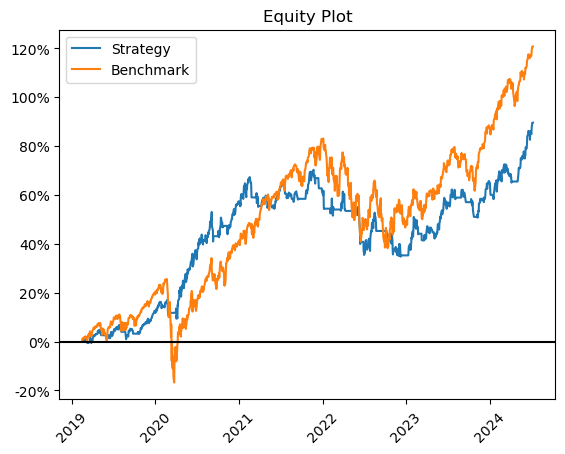

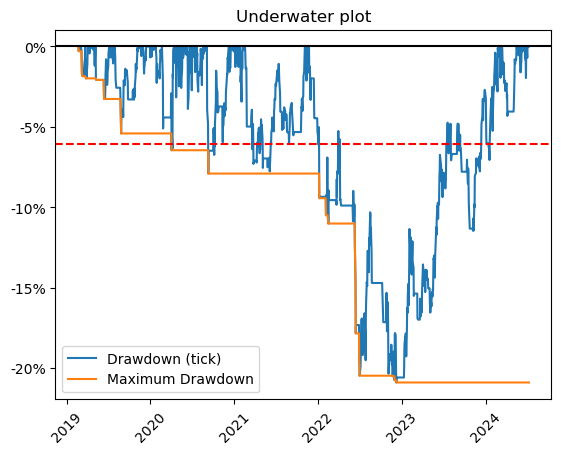

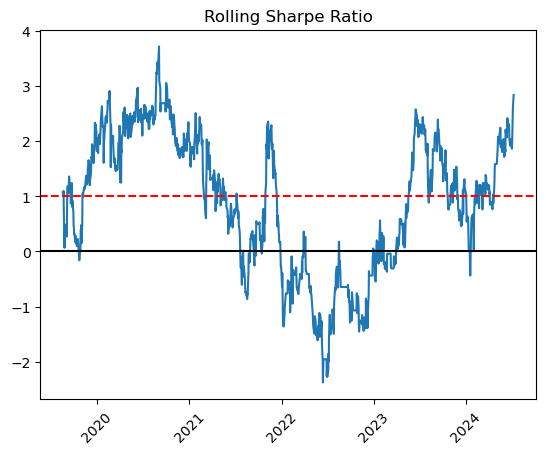

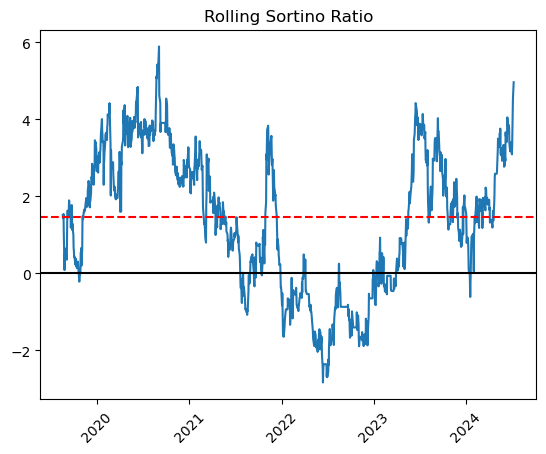

In [3]:
# getting data
data = {}
for asset in MKT:
    ticker = yf.ticker.Ticker(asset.symbol)
    ticker_data = ticker.history(start=LIVE_START, interval='1d')
    data[asset.symbol] = ticker_data

STRATEGY.params = opt_results['best_params']

capital = opt_results['final_equity']

broker = Broker(data=data, initial_capital=capital, currency=usd)
live_backtester = Backtester(data)

live_backtester.run(STRATEGY, broker, save_logs=True)
results = live_backtester.process_results(benchmark=BENCHMARK)
live_backtester.show_report()